## Prepare X_train, X_val, y_train, y_val

In [1]:
import LoadAndPreprocessDataset

(10000, 36, 126)
(10000,)
(3703, 36, 126)
(3703,)


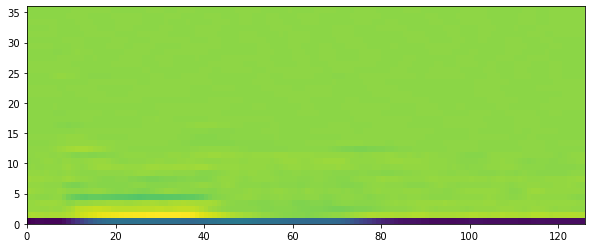

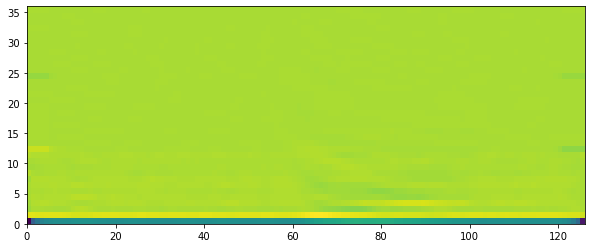

In [2]:
#Load filenames
train,val,test = LoadAndPreprocessDataset.loadDatasetFilenames()

#Load TRAIN files
X,y_train=LoadAndPreprocessDataset.loadBatch(train,batch_size=10000)
#Preprocess TRAIN
X_train=LoadAndPreprocessDataset.MFCC_DELTA_12(X)
#Release memory
del(X)

#Load VAL files
X,y_val=LoadAndPreprocessDataset.loadBatch(val,batch_size=len(val))
#Preprocess VAL
X_val=LoadAndPreprocessDataset.MFCC_DELTA_12(X)
#Release memory
del(X)

In [ ]:
# Look at some data

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.pcolormesh(X_train[0])
plt.show()

plt.figure(figsize=(10, 4))
plt.pcolormesh(X_val[0])
plt.show()

## Define NN

## Test the model

In [ ]:
#Load TEST files
X,y_test=LoadAndPreprocessDataset.loadBatch(val,batch_size=len(test))
#Preprocess TEST
X_test=LoadAndPreprocessDataset.MFCC_DELTA_12(X)
#Release memory
del(X)

In [ ]:
#test.......

## Metrics Summary

In [ ]:
optimal_error=0.01

train_loss=....
val_loss=.....

train_error=1-.....
val_error=1-.....

bias=train_error-optimal_error
variance=val_error-train_error


# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

# Precision and Recall
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)

#F1
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

#ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--") # dashed diagonal
    # Add axis labels and grid
plot_roc_curve(fpr, tpr)
plt.show()

#AUC Score
#perfect classifier=1, purely random=0.5.
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)